This Notebook contains all the deliverables for our Presidential Analysis project.
https://github.com/nickk752/presidential-data-science
Be careful when running all cells, you will unleash the twitter bots.


*Scrape Campaign Speeches*
This code will go to the American Presidency Project campaign speech url passed to scrapeCampaignSpeechesToFile and download all campaign speeches from all candidates in the given election year.  These files are saved in ./Campaign Speeches/[Year]/[candidate-name.txt]

In [40]:
import pandas as pd
import numpy as np
import requests
from lxml import html
from bs4 import BeautifulSoup
import markovify
import os.path
from datetime import datetime, timedelta
import calendar
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
import re


def getCandidateSpeechLinks(url):
    allCandidatePage = requests.get(url)
    allCandidatePageSoup = BeautifulSoup(allCandidatePage.text, 'lxml')
    links={}
    table = allCandidatePageSoup.find('table', width=680)
    for area in table.findAll('td', class_='doctext'):
        for a in area.findAll('a'):
            if ('campaign' in a.text.lower()):
                links[area.find('span', class_='roman').text] = a['href']
    return links

def scrapeCampaignSpeechesToFile(url, path):
    allSpeechPages = requests.get(url)
    allSpeechSoup=BeautifulSoup(allSpeechPages.text, 'lxml')
    root = 'http://www.presidency.ucsb.edu/'
    table = allSpeechSoup.find('table', width=700)
    links = []
    for link in table.findAll('a'):
        if('interview' not in link.text.lower()):
            links.append(root+(link['href'])[3:])

    speechPages = [requests.get(link , 'lxml')for link in links]
    speechesSoup = [BeautifulSoup(speechPage.text, 'lxml') for speechPage in speechPages]

    with open(path, "w+", encoding='utf-8') as outFile:
        outFile.seek(0)
        for i,speech in enumerate(speechesSoup):            
            text = speechesSoup[i].find('span', class_='displaytext').text.replace('.','. ')
            text = re.sub('\[[a-zA-Z]*\]', ' ', text)
            text = re.sub('[A-Z]+ [A-Z]+:', ' ', text)
            text = re.sub('\w+:', ' ', text)
            text = re.sub(r'[^\x00-\x7F]+',' ', text)
            
            outFile.write(text +'\n')


def campaignLinkToFiles(url, year):
    
    dataFolder = './Campaign Speeches/'+ str(year) +'/'
    
    if not os.path.exists(dataFolder):
        os.makedirs(dataFolder)
    
    #Create the dictionary of each candidate's name and link to their campaign speech page    
    campaignSpeechLinkDict = getCandidateSpeechLinks(url)
    
    root = 'http://www.presidency.ucsb.edu/'
    new=0
    existing=0
    newpaths=[]
    #Loops through the campagin speech links, puts each candidate's campagin speeches into individual files
    for name, url in campaignSpeechLinkDict.items():
        path = dataFolder + name.replace(' ', '-') + '.txt'
        if not os.path.isfile(path):
            new+=1
            newpaths.append(path)
            scrapeCampaignSpeechesToFile(root + url, path)
        else:
            existing+=1
    
    
    
    #print some statistics
    print(str(existing), ' files already existed, ignoring.')
    print(str(new), ' files created successfully:')
    for p in newpaths:
        print(p)

campaignLinkToFiles('http://www.presidency.ucsb.edu/2016_election.php', 2016)

20  files already existed, ignoring.
1  files created successfully:
./Campaign Speeches/2016/Carly-Fiorina.txt


*Scrape Tweets from Twitter*
This code will load api keys from twitterkeys.txt, log into the Donald Trump bot, and download every tweet from the candidates specified in ./Twitter/twitterhandles.json.  These tweets are saved as ./Twitter/Tweets/[Tweeter-Name.txt]

In [2]:
import oauth2 as oauth
import urllib.request
from pprint import pprint
import csv
import re
import os
import tweepy
from tweepy import OAuthHandler
import json

keys_path = './twitterkeys.txt'
keys=[]

#load the twitter api keys
with open(keys_path) as f:
    keys=json.load(f)

accountToUse = 'Donald Trump'
keysToUse = keys[accountToUse]
auth = OAuthHandler(keysToUse['cons_key'], keysToUse['cons_secret'])
auth.set_access_token(keysToUse['access_token'], keysToUse['access_token_secret'])

api = tweepy.API(auth)

#load the list of twitter handles to scrape
handles=[]

with open('./Twitter/twitterhandles.json') as f:
    handles= json.load(f)
print(handles)

root = './Twitter/tweets/'

#accepts a twitter handle and a name for the candidate, downloads all the tweets for that candidate and stores them in 
def scrapeTweetsToFile(handle, name):
    
    print(handle)
    alltweets = []

    newtweets=api.user_timeline(screen_name = handle, count=200)
    alltweets.extend(newtweets)
    oldest=alltweets[-1].id -1

    while len(newtweets) > 0:
        print('getting tweets before %s' %(oldest))
        newtweets = api.user_timeline(screen_name=handle, count=200, max_id=oldest)    
        alltweets.extend(newtweets)    
        oldest=alltweets[-1].id - 1
        print('...%s tweets downloaded so far' % len(alltweets))

    outtweets = [[re.sub(r'[^\x00-\x7f]',r' ',tweet.text.replace('&amp;', '&').strip("'").replace('"','').replace('\n', ' '))] for tweet in alltweets]

    with open(os.path.join(root, '%s.txt' % name.replace(' ','-')) , 'w+', encoding='utf8') as f:

        previous=''
        
        #These skip flags ensure that a continued tweet is not split in two
        skipnext=False
        skipcurrent=False
        
        #loop through all the tweets
        for t in outtweets:
            #move the skip next flag to the skip current flag
            skipcurrent=skipnext
            skipnext=False
            
            #if there is a previous tweet and the current tweet starts with '...'
            if previous!='':
                #if the current tweet has .. in the last 6 chars (Trump is messy with his ellipsies)
                if '..' in t[0][-6:]:
                    #set previous to the current tweet with the previous tweet appended to the end, removing all ellipsis-like patterns
                    previous=t[0].strip('...').replace('...',' ')+' '+previous.strip('...').replace('...',' ')
                    #set the flag to skip the next entry
                    skipnext=True
            #if there is a previous tweet that is not a retweet or a reply, and there are no links in the tweet
            if previous != '' and previous[:2] != 'RT' and not '@' in previous[:2] and 'http' not in previous and not skipcurrent: 
                #write the previous tweet to its file
                f.write(previous+'\n') 
            
            #set the previous tweet
            previous=t[0]
    pass

#loop through the twitter handles and scrape the tweets of each one into a file
for handle in handles:
    scrapeTweetsToFile(handles[handle], handle)

{'Ted Cruz': 'tedcruz', 'Donald Trump': 'realDonaldTrump', 'President Obama': 'potus44', 'Bernie Sanders': 'BernieSanders', 'Barack Obama': 'BarackObama', 'Hillary Clinton': 'HillaryClinton'}
tedcruz
getting tweets before 846838294876950527
...400 tweets downloaded so far
getting tweets before 831268728595701761
...600 tweets downloaded so far
getting tweets before 819312643425058815
...800 tweets downloaded so far
getting tweets before 806605605104472064
...999 tweets downloaded so far
getting tweets before 796132220054466559
...1195 tweets downloaded so far
getting tweets before 789315011000664065
...1395 tweets downloaded so far
getting tweets before 781533806335438847
...1595 tweets downloaded so far
getting tweets before 772982519209693183
...1795 tweets downloaded so far
getting tweets before 759133467313438719
...1995 tweets downloaded so far
getting tweets before 748180284785332223
...2195 tweets downloaded so far
getting tweets before 734725803359903744
...2393 tweets download

In [3]:
import string
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import nltk
import glob
import os
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from scipy.cluster.vq import whiten
import re
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
%matplotlib inline

def token_to_pos(ch):
    tokens = nltk.word_tokenize(ch)
    return [p[1] for p in nltk.pos_tag(tokens)]
    

def corpustovector(corpus):
        # create feature vectors
    num_tweets = len(corpus)
    fvs_lexical = np.zeros((len(corpus), 3), np.float64)
    fvs_punct = np.zeros((len(corpus), 3), np.float64)



    for e, tw_text in enumerate(corpus):
        # note: the nltk.word_tokenize includes punctuation
        tokens = nltk.word_tokenize(tw_text.lower())
        words = word_tokenizer.tokenize(tw_text.lower())
        sentences = sentence_tokenizer.tokenize(tw_text)
        vocab = set(words)
        words_per_sentence = np.array([len(word_tokenizer.tokenize(s)) for s in sentences])

        # average number of words per sentence
        fvs_lexical[e, 0] = words_per_sentence.mean()
        # sentence length variation
        fvs_lexical[e, 1] = words_per_sentence.std()
        # Lexical diversity
        fvs_lexical[e, 2] = len(vocab) / float(len(words))

        # Commas per sentence
        fvs_punct[e, 0] = tokens.count(',') / float(len(sentences))
        # Exclamations per sentence
        fvs_punct[e, 1] = tokens.count('!') / float(len(sentences))
        # Colons per sentence
        fvs_punct[e, 2] = tokens.count(':') / float(len(sentences))     
        
 
    # apply whitening to decorrelate the features
    fvs_lexical = whiten(fvs_lexical)
    fvs_punct = whiten(fvs_punct)
    
    # get most common words in the whole book
    NUM_TOP_WORDS = 10
    
    translator = str.maketrans('', '', string.punctuation)

    all_text = ' '.join(corpus)
    all_tokens = nltk.word_tokenize(all_text.translate(translator))
    fdist = nltk.FreqDist(all_tokens)
    vocab = sorted(fdist, key=fdist.get, reverse=True)[:NUM_TOP_WORDS]

    # use sklearn to create the bag for words feature vector for each speech
    vectorizer = CountVectorizer(vocabulary=vocab, tokenizer=nltk.word_tokenize)
    fvs_bow = vectorizer.fit_transform(corpus).toarray().astype(np.float64)

    # normalise by dividing each row by its Euclidean norm
    fvs_bow /= np.c_[np.apply_along_axis(np.linalg.norm, 1, fvs_bow)]
    fvs_bow = np.nan_to_num(fvs_bow)
    
    
    tweets_pos = [token_to_pos(tw) for tw in corpus]
 
    # count frequencies for common POS types
    pos_list = ['NN', 'NNP', 'DT', 'IN', 'JJ', 'NNS']
    fvs_syntax = np.array([[tw.count(pos) for pos in pos_list]
                           for tw in tweets_pos]).astype(np.float64)


    # normalise by dividing each row by number of tokens in the chapter
    fvs_syntax /= np.c_[np.array([len(tw) for tw in tweets_pos])]
    
    
    fvs = np.c_[fvs_lexical , fvs_punct , fvs_bow, fvs_syntax]
    cols=['mean-wps', 'std-wps', 'div-wps', 'commas','ats','colons','bow1','bow2','bow3','bow4','bow5','bow6','bow7','bow8','bow9','bow10','NN', 'NNP', 'DT', 'IN', 'JJ', 'NNS']
    dfCorpus = pd.DataFrame(fvs, columns=cols)
    print(dfCorpus.shape)
    return dfCorpus

In [4]:
nltk.data.path.append('N:\\nltk_data')
sentence_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
word_tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

def concat_tweets(tweets, n):
    concatenated = []
    for i in range(len(tweets) // n):
        appendable = ''
        for x in range(n):
            appendable += (tweets[i + x*n] + ' ')
        concatenated.append(str(appendable)) 
    return concatenated

# Load data
folder = './Campaign Speeches/2016/nltk'
folder2 ='./Twitter/tweets/nltk/'
tweets=[]
labels = []
row_labels = []
for e, file in enumerate(os.listdir(folder)):
    with open(os.path.join(folder, file)) as f:
        newTweets = f.read().split('\n')
        newTweets.pop()
        newTweetsConcat = concat_tweets(newTweets, 1)
        print('Number of Tweets for', \
              file.strip('.txt'), ':', len(newTweetsConcat))
        tweets=tweets+newTweetsConcat
        labels.append(file.strip('.txt'))
        for i in range(len(newTweetsConcat)):
            row_labels.append(e)

dfFeatures = corpustovector(tweets)
df = pd.DataFrame()
df['tweets'] = tweets
df['label'] = row_labels

Number of Tweets for Bernie-Sanders : 29
Number of Tweets for Donald-Trump : 74
(103, 22)


Train several machine learning classifiers on the tweet data

In [5]:
X = dfFeatures
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33)

names= ['kNN', 'Decision Tree', 'Random Forest', 'MLP', 'AdaBoost', 'Gaussian']

#Defines each classifier and puts them in an array
classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(n_estimators = 20, algorithm='SAMME'),
    GaussianNB()]

allScores=[]
# iterate over classifiers
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    scores =  clf.score(X_test, y_test)
    print(clf)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    allScores.append(scores.mean())
    print()

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')
Accuracy: 0.82 (+/- 0.00)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Accuracy: 0.91 (+/- 0.00)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy: 0.97 (+/- 0.00)

MLPClassifier(activation='relu', alpha=1, batch_size='auto', be

Use PCA to reduce the feature vector to 2 dimensions, train the machine learning classifiers on the result, and graph the visualization of each classifier in 2d space

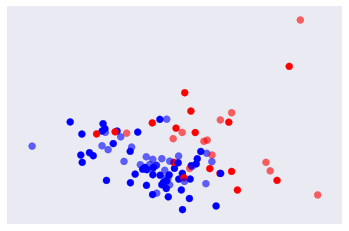

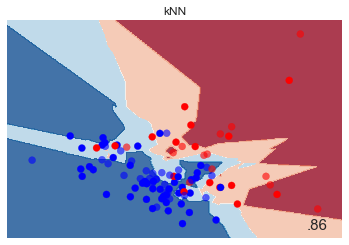

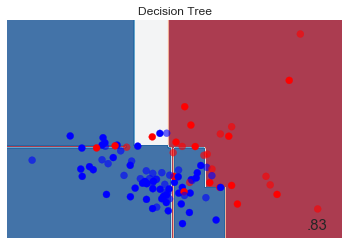

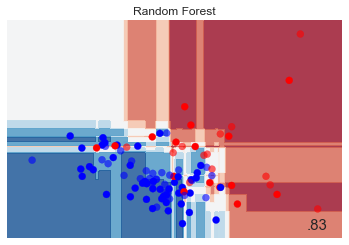

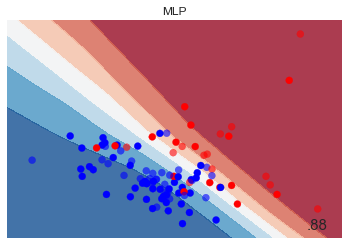

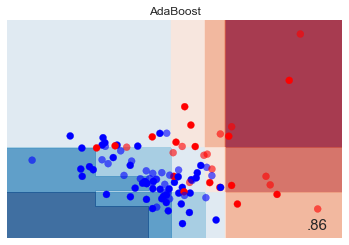

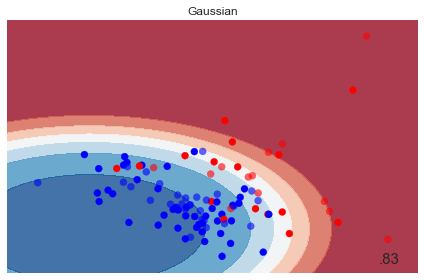

In [6]:
pca = PCA(n_components=2, svd_solver='full')
pca.fit(X)
pcavecs = pca.transform(X)

#figure = plt.figure()
i = 1
# iterate over datasets
h=.02
# preprocess dataset, split into training and test part
X = pcavecs
y = df['label']
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.4, random_state=42)
 
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
 
# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = matplotlib.colors.ListedColormap(['#FF0000', '#0000FF'])
ax = plt.subplot()
 
# Plot the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
# and testing points
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
i += 1
 
# iterate over classifiers
for name, clf in zip(names, classifiers):
    plt.figure()
    ax = plt.subplot()
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)

 
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])            
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
 
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
 
 
    # Plot also the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
               alpha=0.6)
 
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
            size=15, horizontalalignment='right')
    plt.title(name)
 
plt.tight_layout()
#plt.show()

In [7]:
def predict_politician_per_classifer(features, labels, classifer):
    lexical = ['mean-wps', 'std-wps', 'div-wps']
    punc = ['commas', 'ats', 'colons']
    bow = ['bow1','bow2','bow3','bow4','bow5','bow6','bow7','bow8','bow9','bow10']
    syntactic = ['NN', 'NNP', 'DT', 'IN', 'JJ', 'NNS']

    feature_sets = [lexical, punc, bow, syntactic]
    feature_set_names = ['Lexical', 'Punctuation', 'Bag of Words', 'Syntactic']
    
    accuracies = ''
    
    for feature_set, name in zip(feature_sets, feature_set_names):
        X_train, X_test, y_train, y_test = \
            train_test_split(features[feature_set], labels, test_size=.4)
        clf = classifer
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        score_str = "%0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2)
        accuracy_str = str(name + ': ' + score_str)
        accuracies += (accuracy_str + '\n')
    
    return accuracies

In [8]:
names= ['kNN', 'Decision Tree', 'Random Forest', 'MLP', 'AdaBoost', 'Gaussian']

#Defines each classifier and puts them in an array
classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(n_estimators = 20, algorithm='SAMME'),
    GaussianNB()]

for clf, name in zip(classifiers, names):
    print(name, str(':\n'+ predict_politician_per_classifer(dfFeatures, row_labels, clf)))

kNN :
Lexical: 0.90 (+/- 0.00)
Punctuation: 0.67 (+/- 0.00)
Bag of Words: 0.88 (+/- 0.00)
Syntactic: 0.95 (+/- 0.00)

Decision Tree :
Lexical: 0.81 (+/- 0.00)
Punctuation: 0.67 (+/- 0.00)
Bag of Words: 0.90 (+/- 0.00)
Syntactic: 0.81 (+/- 0.00)

Random Forest :
Lexical: 0.83 (+/- 0.00)
Punctuation: 0.67 (+/- 0.00)
Bag of Words: 0.90 (+/- 0.00)
Syntactic: 0.88 (+/- 0.00)

MLP :
Lexical: 0.93 (+/- 0.00)
Punctuation: 0.79 (+/- 0.00)
Bag of Words: 0.83 (+/- 0.00)
Syntactic: 0.79 (+/- 0.00)

AdaBoost :
Lexical: 0.93 (+/- 0.00)
Punctuation: 0.76 (+/- 0.00)
Bag of Words: 0.93 (+/- 0.00)
Syntactic: 0.86 (+/- 0.00)

Gaussian :
Lexical: 0.81 (+/- 0.00)
Punctuation: 0.69 (+/- 0.00)
Bag of Words: 0.95 (+/- 0.00)
Syntactic: 0.83 (+/- 0.00)



Now time to build the classifier for campaign speeches!

In [9]:
root='./Campaign Speeches/2016/nltk/'
candidates=os.listdir(root)
tweets=[]
labels = []
y=[]
for e, file in enumerate(os.listdir(root)):
    with open(os.path.join(root, file)) as f:
        newTweets = f.read().split('\n')
        newTweets.pop()
        tweets=tweets+newTweets
        for i in range(len(newTweets)):
            labels.append(file.strip('.txt'))
            y.append(e)
        
all_text = ' '.join(tweets)

dfFeatures = corpustovector(tweets)
df=pd.DataFrame()
df['tweets']=tweets
df['label']=y




(103, 22)


In [10]:
X = dfFeatures
y = df['label']


names= ['kNN', 'Decision Tree', 'Random Forest', 'MLP', 'AdaBoost', 'gaus']

#Defines each classifier and puts them in an array
classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(warm_start=True, n_jobs=-1, n_estimators =20, max_depth=19,  max_features=None, criterion='entropy'),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(n_estimators = 20, algorithm='SAMME'),
    GaussianNB()]


allScores=[]
# iterate over classifiers
for name, clf in zip(names,
                     classifiers):
    scores =  cross_val_score(clf, X, y, cv=5)
    print(clf)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    allScores.append(scores.mean())
    print()



KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')
Accuracy: 0.79 (+/- 0.16)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Accuracy: 0.86 (+/- 0.32)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=19, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=True)
Accuracy: 0.88 (+/- 0.27)

MLPClassifier(activation='relu', alpha=1, batch_size='auto', bet

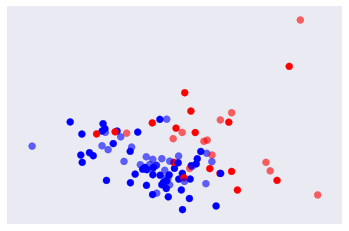

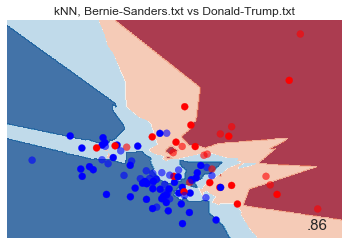

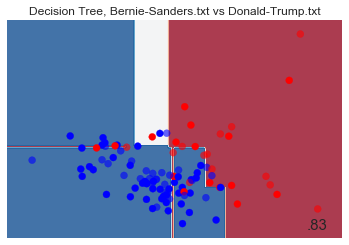

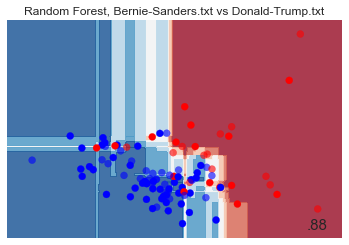

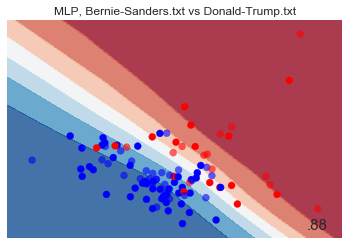

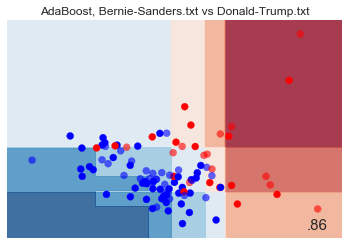

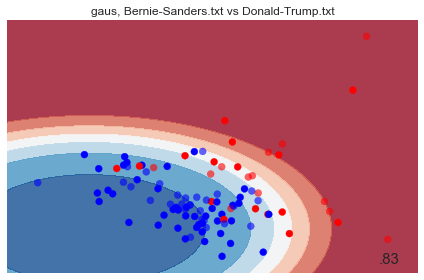

In [11]:
pca = PCA(n_components=2, svd_solver='full')
pca.fit(dfFeatures)
pcavecs = pca.transform(dfFeatures)

i = 1
# iterate over datasets
h=.02
# preprocess dataset, split into training and test part
X = pcavecs
y = df['label']
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.4, random_state=42)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = matplotlib.colors.ListedColormap(['#FF0000', '#0000FF'])
ax = plt.subplot()

# Plot the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
# and testing points
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
i += 1

# iterate over classifiers
for name, clf in zip(names, classifiers):
    plt.figure()
    ax = plt.subplot()
    #ax.set_title(name+' '+sub+', '+' vs '.join(candidates))
    ax.set_title(name+', '+' vs '.join(candidates))
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])            
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)


    # Plot also the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
               alpha=0.6)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
            size=15, horizontalalignment='right')
    i += 1

plt.tight_layout()

**Twitter Bot**

In [31]:
import twitter
import os
from markovbot import MarkovBot
import json
from pprint import pprint
import markovify
from html.parser import HTMLParser

keys_path = './twitterkeys.txt'
speech_root='./Campaign Speeches/2016/'
handles_path='./Twitter/twitterhandles.json'


keys=[]

#load the twitter api keys
with open(keys_path) as f:
    keys=json.load(f)


presidents=[p for p in keys]
print('Found Twitter API Keys for: ',', '.join(presidents))


bots={}

#get path to tweets from all the candidates
root = './Twitter/Tweets'
tweet_paths = [f for f in os.listdir(root) if os.path.isfile(os.path.join(root, f))]
print('Found Tweets for ', ', '.join(tweet_paths))

Found Twitter API Keys for:  Hillary Clinton, Donald Trump, Bernie Sanders
Found Tweets for  Ben-Carson.txt, Bernie-Sanders.txt, Bobby-Jindal.txt, Chris-Christie.txt, Donald-Trump.txt, George-Pataki.txt, Hillary-Clinton-.txt, Jeb-Bush.txt, Jim-Webb.txt, John-Kasich.txt, Lincoln-Chafee.txt, Lindsey-Graham.txt, Marco-Rubio.txt, Martin-O'Malley.txt, Mike-Huckabee.txt, Rand-Paul.txt, Rick-Perry.txt, Rick-Santorum.txt, Scott-Walker.txt, Ted-Cruz.txt


In [32]:
#make a markov bot for each politician's tweets
for path in tweet_paths:
    bot = MarkovBot()
    corpus = os.path.join(root, path)
    bot.read(corpus)
    #Generate a tweet from the newly made bot
    print(bot.generate_text(140))
    bots[path[:-4].replace('-',' ')]=bot
print(bots)

As members of Congress to work has the law and don't even know it.
Together we're going to overturn legislation passed by states that calls for massive tax cuts to basic needs.
I have thousands of jobs and wants massive tax hikes.
He may be up at 3 o'clock in the world is watching what we build, but the hospital wouldn't admit her without proof of insurance.
As we look ahead to the @Warriors, a great moral voice of our children.
It's time to take on the debate stage with Hillary Clinton in November #RNCinCLE.
{'Ted Cruz': <markovbot.MarkovBot object at 0x000001F23076F908>, 'Donald Trump': <markovbot.MarkovBot object at 0x000001F22EBA1400>, 'President Obama': <markovbot.MarkovBot object at 0x000001F22F262080>, 'Bernie Sanders': <markovbot.MarkovBot object at 0x000001F22EA9BD30>, 'Barack Obama': <markovbot.MarkovBot object at 0x000001F22CFDDE48>, 'Hillary Clinton': <markovbot.MarkovBot object at 0x000001F22EAA55F8>}


In [33]:
#log into the Donald and Hillary twitter accounts with the api keys
for pres in presidents:
    bots[pres].twitter_login(keys[pres]['cons_key'],keys[pres]['cons_secret'],keys[pres]['access_token'],keys[pres]['access_token_secret'])

Set all three twitter bots to tweet every 10 minutes

In [34]:
for bot in bots:
    bots[bot].twitter_tweeting_start(days=0, hours=0, minutes=10, keywords=None, prefix=None, suffix=None)

In [35]:
for bot in bots:
    bots[bot].twitter_tweeting_stop()

Automatically respond to tweets that contain 'crooked'.  Always gets some angry responses.

In [36]:
bots['Hillary Clinton'].twitter_autoreply_start('crooked', mindelay=1.5)

In [37]:
bots['Hillary Clinton'].twitter_autoreply_stop()

Train bots on all the 2016 presidential candidates' campaign speeches.

In [41]:
speech_bots = {}

#make a markov bot for each politician's campaign speeches
speech_paths = [f for f in os.listdir(speech_root) if os.path.isfile(os.path.join(speech_root, f)) and 'Fiorina' not in f]
for path in speech_paths:
    bot = MarkovBot()
    corpus = os.path.join(speech_root, path)
    bot.read(corpus)
    #Generate a tweet from the newly made bot
    print(bot.generate_text(140))
    speech_bots[path[:-4].replace('-',' ')]=bot
print(speech_bots)

We have our chairman, which is the number of people they really all.
Making -- there are 11 million undocumented people cannot continue to fight and keep our pension promise to you.
So we had to make the best states in the world, where you could get ahead if you want somebody else.
You see, the reason that's true is because we have an economy that is bankrupting our country.
So, we are going to have millions and millions of talented, aspiring Americans on the ladder of a dirt road.
Let us move forward so that just as the foundation of that young child growing up in that small town believed in ourselves.
Our democracy is to pay them.
It's everybody's test, and it's wide open exactly as a reliable actor in the defeat of radical Islamic terrorism wherever it appears.
We know that because of the importance of Vietnam when it transitions from an RFD-TV viewer, Senator.
This is exactly what I've done in the Oval Office, I will also provide support and friendship for our values and ideas.
I w

In [39]:
for speech_bot in speech_bots:
    print(speech_bot)
    for i in range(10):
        print(speech_bots[speech_bot].generate_text(140))
    print('\n\n')

Lincoln Chafee
So we've got to surpluses, the last 10, 14 years.
Eighteen of us who originally sponsored it and I just about fell off my chair.
As one who voted against Iraq War and the United Nations is going to pay for it.
In fact, we had a great pleasure to join the choices out there.
If we're smart with our diplomacy, we can come out of these subsidies for agricultural products in particular.
Let's get out of college with while many, many Americans are our professional diplomats stationed all over the world.
[On LGBT issues] Yes, I've had a chance to own their own reasons for voting no.
[On LGBT issues] Yes, I've had a bill to do more for Native Americans.
First, just don't make mistakes, and I was just looking at it the other people in the Pentagon.
Let's join the rest of the Republicans running for president today.



Ben Carson
That is why we are probably at least in her opinion.
[cheers and applause] I am Ben Carson and I am probably never going to do, to try to rule us.
I don'